In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import fenics
import dolfin
from fenics import *
from hmm.stokes import StokesData, StokesHMMWrapper, HyperParams
from hmm.stokes_fenics import StokesData as StokesDataFenics
from hmm.stokes_fenics import StokesMacProb as MacProbFenics
from hmm.stokes_fenics import MacroSolver as MacSolverFenics
from hmm.stokes_fenics import MacroSol as MacroSolFenics
from util.basis_scaled import *
from stokes2d.robin_solver import solveRobinStokes_fromFunc
from dolfin import *
import matplotlib.pyplot as plt
from util.plot_tools import remove_axes, remove_top_right_axes, plot_periodic
from mshr import *
import boundary_solvers.geometry as geom
import boundary_solvers.gauss_grid_2d as grd
from util.interp import PiecewiseInterp2D
import dolfin as dl
import time

from mshr.cpp import CSGScaling, CSGTranslation

Meshing time: 0.02688765525817871


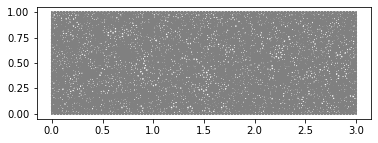

In [2]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):
    def __init__(self, dom):
        SubDomain.__init__(self)
        self.L = dom[0][1] - dom[0][0]
        self.dom = dom

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(near(x[0], self.dom[0][0]) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - self.L
        y[1] = x[1]


Lx, Ly = 3, 1
bbox = [[0, Lx], [0, Ly]]

Nx = 50
res = 50
Ny = int(Nx * Ly/Lx)

xDom = np.linspace(*bbox[0], Nx)
yDom = np.linspace(*bbox[1], Ny)[1:-1]


pts = [Point(x, bbox[1][0]) for x in xDom]
pts = pts + [Point(bbox[0][1], y) for y in yDom]
pts = pts + [Point(x, bbox[1][1]) for x in xDom[::-1]]
pts = pts + [Point(bbox[0][0], y) for y in yDom[::-1]]

t = time.time()
domain = Polygon(pts) # Rectangle(Point(bbox[0][0], bbox[1][0]), Point(bbox[0][1], bbox[1][1]))
dom_mesh = generate_mesh(domain, resolution=res)
print(f'Meshing time: {time.time()-t}')

class Floor(dl.SubDomain):
    def inside(self, x, on_boundary):
        return bool(dl.near(x[1], bbox[1][0]) and not dl.near(x[0], bbox[0][0]) and not dl.near(x[0], bbox[0][1]))

plot(dom_mesh)


In [3]:

# Define the four boundaries + circle
roof = f'near(x[1],{bbox[1][1]})'
floor = f'near(x[1], {bbox[1][0]})'

inflow = f'near(x[0], {bbox[0][0]}) && !{floor} && !{roof}'
outflow = f'near(x[0],{bbox[0][1]}) && !{floor} && !{roof}'

# Define the function spaces
pb = PeriodicBoundary(bbox)
P2 = VectorElement(family='P', cell=triangle, degree=2)
P1 = FiniteElement(family='P', cell=triangle, degree=1)
P2P1 = P2 * P1
W = FunctionSpace(dom_mesh, P2P1, constrained_domain=pb)
#U = W.sub(0)#extract_sub_space([0])    
U, P = W.split()    
Uy = U.sub(1)
Ux = W.sub(0).sub(0).collapse()

# Forces
f = Constant((0,0))
a_lamb = lambda x, y:  0.1 + 0.03 * np.sin(x * 2*np.pi / Lx)
alf_inv = Function(W.sub(1).collapse())
ind = Function(W.sub(1).collapse())
n = FacetNormal(dom_mesh)

#a = Expression(f'{floor} /(0.1 + 0.03 * sin(x[0] * 2 * pi /{Lx}))', degree=1)
#a = lambda x, y: near(x[1], bbox[1][0]) / afunc(x[0], x[1])
#bdry = Expression(f'(1-near(x[0], {bbox[0][0]})) * (1-near(x[0], {bbox[0][1]}))', degree=1)
#ds_robin = Measure('ds', domain = dom_mesh, subdomain_data = floor)

(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)


# Boundary Conditions
bcu_roof = DirichletBC(U, Expression((f'1', '0'), degree=2), roof)
bcu_floor = DirichletBC(Uy, Constant(0), floor)
bcu = [bcu_roof, bcu_floor]

data = StokesDataFenics.from_mesh(dom_mesh, Floor(), None, W, bcu)
mac_prob = MacProbFenics(data, interp=None, alpha0=a_lamb)
mac_solv = MacSolverFenics(mac_prob)
sol = mac_solv.solve(mac_prob)

t = time.time()
#F = - p*dot(v,n)*ds -(dot(u,v) - dot(u,n)*dot(v,n))*alf*ds - inner(grad(u),grad(v))*dx + p*div(v)*dx+ dot(u,grad(q))*dx - dot(f ,v)*dx - dot(u, n)*q*ds
#a, L = lhs(F), rhs(F)



alf_inv.vector()[:] = np.array([1./a_lamb(x, y) if near(y, bbox[1][0]) else 0. for x, y in W.sub(1).collapse().tabulate_dof_coordinates()])
ind.vector()[:] = np.array([1. if near(y, bbox[1][0]) and not near(x, bbox[0][0]) and not near(x, bbox[0][1]) else 0. for x, y in W.sub(1).collapse().tabulate_dof_coordinates()]) #Floor().inside(np.array([x, y]), True)

lam = 0.
def proj_n(u): return dl.dot(u, n)
def grad_n_proj_n(u): return proj_n(dl.grad(proj_n(u)))
def a(u, v, p, q): return dl.inner(dl.grad(u), dl.grad(v))*dl.dx - (p * dl.div(v) + q * dl.div(u))*dl.dx
def b(u, v, p, q): return (proj_n(v) * (p - grad_n_proj_n(u)) + proj_n(u) * (q - grad_n_proj_n(v))) * ind * dl.ds
def c(u, v): return (dl.dot(u,v) - proj_n(u) * proj_n(v)) * alf_inv * dl.ds
def r(u, v, p, q): return (q * p + proj_n(u) * proj_n(v)) * ind * dl.ds

a = a(u, v, p, q) + b(u, v, p, q) + c(u, v) + lam * r(u, v, p, q)
L = dl.dot(f, v)*dl.dx
print(f'Assembling time: {time.time()-t}')

t = time.time()
w = Function(W)
solve(a == L, w, bcu)
print(f'Solving time: {time.time()-t}')

            

def extract_components(w, W):
    u=project(w[0], W.sub(0).sub(0).collapse())
    v=project(w[1], W.sub(0).sub(1).collapse())
    p=project(w[2], W.sub(1).collapse())
    return u, v, p

Solving linear variational problem.
Assembling time: 0.021781206130981445
Solving linear variational problem.
Solving time: 0.8140480518341064


In [4]:
zero2d = lambda x,y: np.zeros_like(x).astype(np.complex128)
zero = lambda x: np.zeros_like(x).astype(np.complex128)
gx = lambda x: np.ones_like(x)
gy = lambda x: np.zeros_like(x)
dom = bbox
uSpec, vSpec, info = solveRobinStokes_fromFunc(zero2d, zero2d, lambda x: -a_lamb(x, 0*x), gx, zero, gy, zero, dom, 4*Nx+1, 4*Ny+1, tol=1e-5)

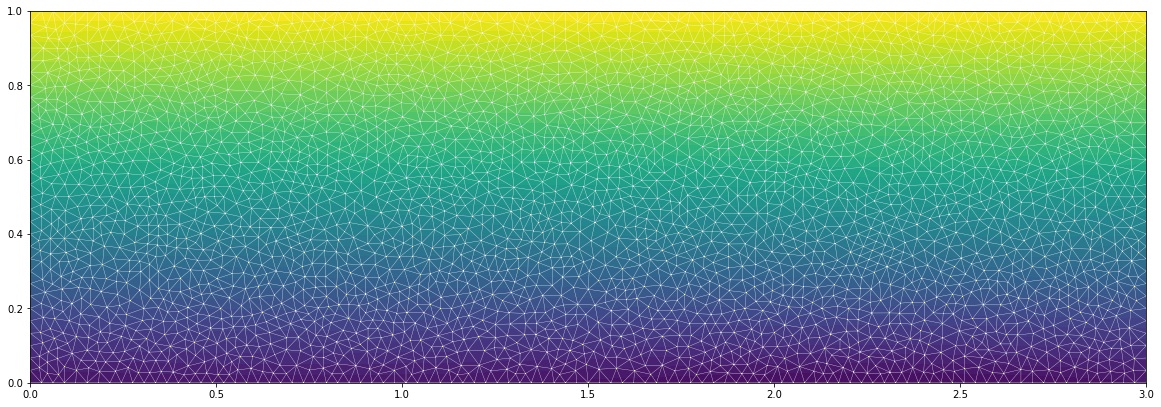

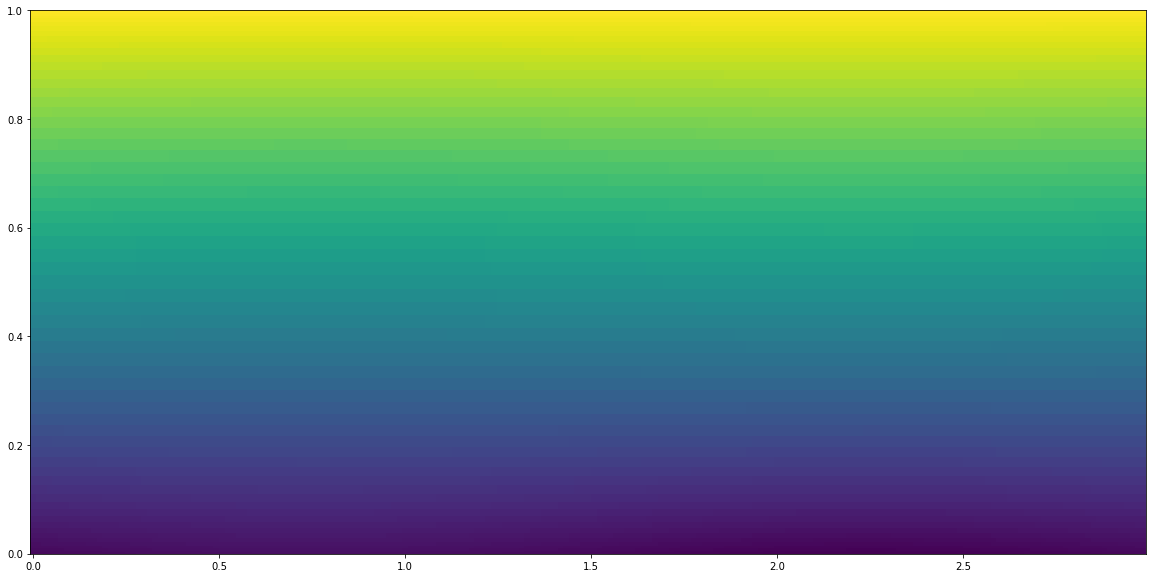

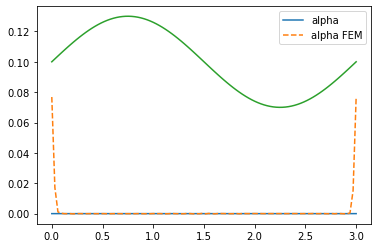

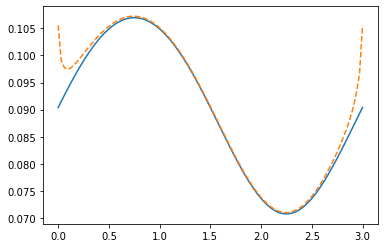

In [6]:
u, v, p = extract_components(w, W)
#u = sol.u
#v = sol.v

# evaluate derivative of u at point (x,y)
udy = project(u.dx(1),  W.sub(0).sub(0).collapse())

plt.figure(figsize=(20,10))
plot(u)#(u**2 + v**2)**0.5)
plot(dom_mesh, color='white', linewidth=0.3)

plt.figure(figsize=(20,10))
uSpec.plot(plt.gca())
uSpec_dy = uSpec.diff(0,1)

plt.figure()
x = np.linspace(bbox[0][0], bbox[0][1], 100)
y = 0*x
plt.plot(x, uSpec(x, y) - a_lamb(x, y)*uSpec_dy(x, y), label='alpha')
plt.plot(x, np.array([u(xi, yi) - a_lamb(xi, yi)*udy(xi, yi) for xi, yi in zip(x, y)]), '--', label='alpha FEM')
plt.plot(x, a_lamb(x, np.ones_like(x)*0))
plt.legend()

plt.figure()
x = np.linspace(bbox[0][0], bbox[0][1], 100)
y = 0*x
plt.plot(x, uSpec(x, y), label='alpha')
plt.plot(x, np.array([u(xi, yi) for xi, yi in zip(x, y)]), '--', label='alpha FEM')

